In [1]:
from scipy import odr
from sympy import symbols, solve, exp, lambdify, integrate
from sympy import Function, Derivative, dsolve
from sympy.plotting.plot import plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Start the testing data at 150um from the QC, since this is when the last division takes place
TIMES =  [6.7, 11, 15, 18, 20, 21, 22]
PRECURSORS = [1.5, 1.65, 2, 2.35, 2.85, 2.65, 2.65]
SIZES = [8.5, 9, 13, 20, 30, 42, 55]

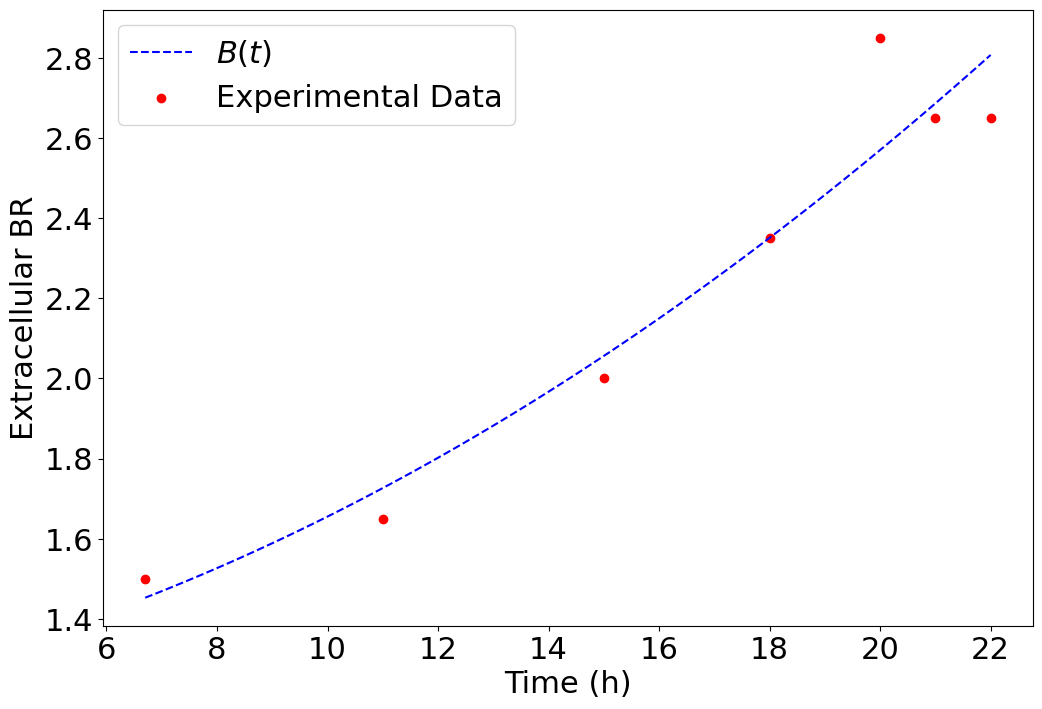

In [3]:
# Find the polynomial of best fit and graph it
BR = np.poly1d(np.polyfit(TIMES, PRECURSORS, 2))
xs = np.linspace(min(TIMES), max(TIMES), 100)
plt.plot(xs, BR(xs), color = "blue", ls = "--", label = r"$B(t)$")

# Add a scatterplot of the original points
plt.scatter(TIMES, PRECURSORS, color = "red", label = "Experimental Data")
plt.xlabel("Time (h)")
plt.ylabel("Extracellular BR")
plt.legend()
plt.savefig("img/prototype-2-br.png")

## Non-Dimensional Equations

$$
\begin{cases}
\dfrac{ dC^{*} }{ d\tau  } = \pi _{1} - \pi _{1}(1 + \pi _{4}R_{B}^{*})C^{*} \\[5pt]
\dfrac{ dR_{0}^{*} }{ d\tau  } = \pi_{5}(1 + \pi _{3}C^{*}) -(1 +  \pi_{5}B)R_{0}^{*} + \pi _{5}\pi _{6}R_{B}^{*} \\[5pt]
\dfrac{ dR_{B}^{*} }{ d\tau  } =  \pi _{7}R_{0}^{*}B - (1 + \pi _{8})R_{B}^{*} \\[5pt] 
\dfrac{ dM^{*} }{ d\tau  } =\pi _{3}\pi _{2} - \pi _{2}M^{*} \\[5pt]
\dfrac{ dL^{*} }{ d\tau  } = \pi _{2} + \pi _{2}R_{B}^{*} \left( 1 + \dfrac{ \pi _{9}M^{*} }{ L^{*} } \right) ^{ -1 }
\end{cases}
$$



In [4]:
# BEST NON-DIMENSIONAL PARAMS: [1, 0.26, 0.15, 29.04, 1.02, 1.92, 1.4, 1, 4.58]
# BEST NON-DIMENSIONAL ERROR: 64.8

CONFIG = {
    "start": 6.7,
    "stop": 22,
    "step": 0.05
}

length = 8.5
params = [1, 0.26, 0.15, 29.04, 1.02, 1.92, 1.4, 1, 4.58]
SERIES = np.arange(CONFIG["start"], CONFIG["stop"] + CONFIG["step"], CONFIG["step"])

In [5]:
def setup(params):

    # Define parameters and variables
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = params
    
    # Define the initial cell length and symbols
    C, R0, RB, M, B = symbols('C R0 RB M B')
            
    # Solve the system at steady state
    system = [
        p1 - p1*(1 + p4*RB)*C,
        p5*(1 + p3*C) - (1 + p5*B)*R0 + p5*p6*RB,
        p7*R0*B - (1 + p8)*RB,
        p3*p2 - p2*M
    ]

    # Choose the second root to ensure positive solutions
    ss = solve(system, [C, R0, RB, M], dict = True)[-1]
    return [lambdify(B, ss[h]) for h in [C, R0, RB, M]]

In [6]:
def get_growth(RB, M, length, params): 
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = params
    return p2 + p2*RB/(1 + p9*M/length)

def check_error(sizes): 
    indices = [int((t - CONFIG["start"]) / CONFIG["step"]) for t in TIMES]
    sizes = [sizes[i] for i in indices]
    return sum([(a - b) ** 2 for a, b in zip(sizes, SIZES)])

def simulate_cell(length, params):

    sizes = []
    funcs = setup(params)
    
    for t in SERIES:
        C, R0, RB, M = [f(BR(t)) for f in funcs]
        length += get_growth(RB, M, length, params) * CONFIG["step"]
        sizes.append(length)

    error = check_error(sizes)
    return sizes, error

ERROR: 64.84981705406189


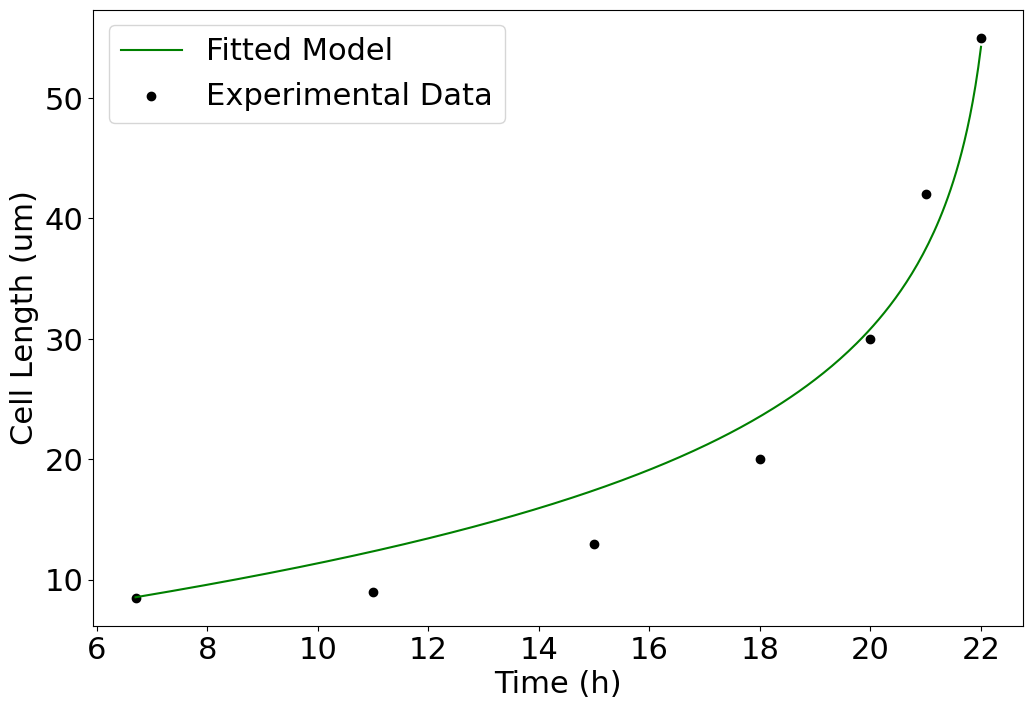

In [7]:
# Test the current parameters against observed data
sizes, error = simulate_cell(length, params)

# Plot the results
plt.plot(SERIES, sizes, color = "green", label = "Fitted Model")
plt.scatter(TIMES, SIZES, color = "black", label = "Experimental Data")
plt.xlabel("Time (h)")
plt.ylabel("Cell Length (um)")
plt.legend()
plt.savefig("img/prototype-3-model.png")
print("ERROR:", error)

In [12]:
def get_parameter_lists(params, step):
    
    params_list = []
    
    for i, p in enumerate(params):
        
        if params[i] > step:
            pi_low = params.copy()
            pi_low[i] = round(pi_low[i] - step, 5)
            params_list.append(pi_low)

        if params[i] < 100: 
            pi_high = params.copy()
            pi_high[i] = round(pi_high[i] + step, 5)
            params_list.append(pi_high)
        
    return params_list     


def optimize_parameters(length, initial_params):

    current_params = initial_params
    current_sizes, current_error = simulate_cell(length, initial_params)
    step = 0.001
    
    while True:

        # Generate a list of lists of new parameters to search through
        params_list = get_parameter_lists(current_params, step)
    
        # Check the error on each of these lists of parameters and find the lowest one
        tests = []
        for params in params_list:
            sizes, error = simulate_cell(length, params)
            tests.append((error, params))

        # Find the smallest error in the tests:
        best_error, best_params = sorted(tests, key = lambda t : t[0])[0]

        # Repeat the process until the current parameters are optimal
        if best_error + step >= current_error:
            break
        
        print("BEST ERROR: ", best_error)
        print("BEST PARAMS: ", best_params)
        current_params = best_params
        current_error = best_error

    return current_params

optimize_parameters(length, params)